## Analysis of News Outlet Tweet Sentiment

### Tweet sentiment was neutral for a large portion of the tweets analyzed

* Vader sentiment analyzer did not pick up on positive or negative sentiment for many of the news tweets, as can been seen by the large number of dots with tweet polarity of zero.

<img style="left;" src="Sentiment Analysis of Media Tweets.png" width=90%/>

### Average tweet sentiment was negative for most news outlets

* I re-ran this analysis for several days to see how the overall mean sentiment score for news organizations might change over time.  Some news outlets did move between a positive and negative mean compound score over time, but the majority of them stayed in the negative range, as can be seen in the overall mean compound scores below.

<img style="left;" src="Overall Media Sentiment on Twitter.png" width=70%/>

### Tweet Sentiment Ratings Change as Expected based on Story Subject Matter

* I used simple keyword search terms to categorize about 25% of the tweets, and found that the story subject matter seems to be largely responsible for the overall sentiment of the tweet.  As can be seen in the overall compound sentiment for the tweets by category, the more negative subject matter yeilded more negative sentiment ratings from Vader, and more positive subject matter yeilded positive sentiment ratings from Vader.  This finding suggests that the overall negative ratings of most of the news organizations reveiwed here is likely due to the choice of topics for their tweets versus the tone of writing in the tweet.

<img style="left;" src="Overall Media Sentiment by Tweet Story Category.png" width=70%/>

In [2]:
# Dependencies
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import date
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Identify New Organizations' Twitter Handles
target_users = ("BBCBreaking", "CBSNews", "CNNbrk", "FoxNews", "nytimes")

# List to hold sentiments
sentiments = []

In [4]:
# Loop through all news organizations
for user in target_users:
    
    # Variable for holding the oldest tweet
    counter = 1
    #oldest_tweet = None
    
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(1, 6):
        
        # Get all tweets from home feed
        public_tweets = api.user_timeline(user, page=x)
        
        # Loop through all tweets
        for tweet in public_tweets:
            
            # Run Vader Analysis on each tweet
            tweet_text = tweet["text"]
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            
            if "sport" in str(tweet["text"].lower()):
                keyword = "Sports"
            elif "war" in str(tweet["text"].lower()) \
                or "dead" in str(tweet["text"].lower()) \
                or "crash" in str(tweet["text"].lower()) \
                or "kill" in str(tweet["text"].lower()):
                keyword = "Disaster/War"
            elif "politic" in str(tweet["text"].lower()) \
                or "election" in str(tweet["text"].lower()) \
                or "vote" in str(tweet["text"].lower()):
                keyword = "Politics"
            elif "legal" in str(tweet["text"].lower()) \
                or "court" in str(tweet["text"].lower()) \
                or "jail" in str(tweet["text"].lower()) \
                or "criminal" in str(tweet["text"].lower()) \
                or "judge" in str(tweet["text"].lower()):
                keyword = "Legal/Criminal"
            else:
                keyword = "Other"
                        
            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            #oldest_tweet = tweet['id'] - 1
            
            # Add tweet data and sentiments for each tweet to a list
            sentiments.append({"Source Account": user,
                               "Date": tweet["created_at"],
                               "Structured Timestamp": time.strptime(tweet["created_at"],'%a %b %d %H:%M:%S +0000 %Y'),
                               "Tweets Ago": counter,
                               "Tweet Text": tweet_text,
                               "Tweet Category": keyword,
                               "Compound": compound,
                               "Positive": pos,
                               "Neutral": neu,
                               "Negative": neg,
                                })
            
            # Add to counter
            counter = counter + 1

In [5]:
# Convert tweet data and sentiments to dataframe
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd['Source Account'] = sentiments_pd['Source Account'].replace(['BBCBreaking'],'BBC')
sentiments_pd['Source Account'] = sentiments_pd['Source Account'].replace(['CBSNews'],'CBS')
sentiments_pd['Source Account'] = sentiments_pd['Source Account'].replace(['CNNbrk'],'CNN')
sentiments_pd['Source Account'] = sentiments_pd['Source Account'].replace(['FoxNews'],'Fox')
sentiments_pd['Source Account'] = sentiments_pd['Source Account'].replace(['nytimes'],'New York Times')
sentiments_pd = sentiments_pd[['Source Account','Date','Structured Timestamp','Tweets Ago','Tweet Text','Tweet Category','Compound','Positive','Neutral','Negative']]
sentiments_pd.head()

,Source Account,Date,Structured Timestamp,Tweets Ago,Tweet Text,Tweet Category,Compound,Positive,Neutral,Negative
0,BBC,Wed Aug 01 16:05:18 +0000 2018,"(2018, 8, 1, 16, 5, 18, 2, 213, -1)",1,RT @BBCSport: The FA is considering putting En...,Sports,0.0000,0.000,1.000,0.000
1,BBC,Wed Aug 01 09:41:30 +0000 2018,"(2018, 8, 1, 9, 41, 30, 2, 213, -1)",2,Former EDL leader Tommy Robinson freed on bail...,Legal/Criminal,0.4767,0.346,0.506,0.148
2,BBC,Tue Jul 31 21:41:13 +0000 2018,"(2018, 7, 31, 21, 41, 13, 1, 212, -1)",3,Plane with at least 80 on board crashes in Mex...,Disaster/War,0.0000,0.000,1.000,0.000
3,BBC,Tue Jul 31 15:49:55 +0000 2018,"(2018, 7, 31, 15, 49, 55, 1, 212, -1)",4,"UK man jailed for 17 years for manslaughter, a...",Legal/Criminal,-0.7783,0.000,0.726,0.274
4,BBC,Mon Jul 30 09:16:49 +0000 2018,"(2018, 7, 30, 9, 16, 49, 0, 211, -1)",5,Doctors and families can agree to allow people...,Legal/Criminal,-0.2192,0.178,0.608,0.214


In [6]:
# Export sentiments_pd to csv file
min_date = time.strftime('%b %d', min(sentiments_pd["Structured Timestamp"]))
max_date = time.strftime('%b %d, %Y', max(sentiments_pd["Structured Timestamp"]))
sentiments_pd.to_csv(f"Media_Tweet_Sentiment_Sample_{min_date}_to_{max_date}.csv", encoding='utf-8')

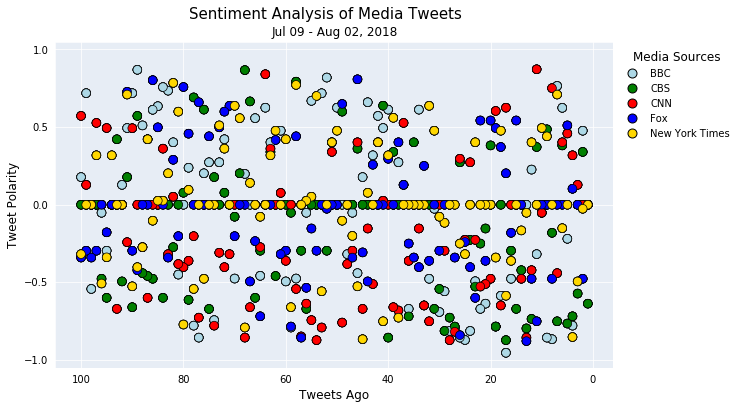

In [7]:
# Scatter plot to show tweet sentiment of individual tweets by media source
x_val = sentiments_pd["Tweets Ago"]
y_val = sentiments_pd["Compound"]
sources = list(sentiments_pd["Source Account"].unique())

fig, ax = plt.subplots(figsize=(10,6))
ax.grid()
colors = {'BBC':'lightblue',
          'CBS':'g',
          'CNN':'r',
          'Fox':'b',
          'New York Times':'gold'}

for source, color in zip(sources, colors):
    ax.scatter(x_val, y_val,
               c=sentiments_pd['Source Account'].apply(lambda x: colors[x]),
               label=source, marker='o', s=75, edgecolors='k', linewidths=0.7)

# Incorporate other graph properties
plt.suptitle(f"Sentiment Analysis of Media Tweets", x=0.5, y=0.96, fontsize=15)
plt.title(f"{min_date} - {max_date}", fontsize=12)
plt.xlim([x_val.max()+5,x_val.min()-5])
plt.ylim([-1.05, 1.05])
plt.yticks(np.arange(-1,1.1, 0.5))
plt.ylabel("Tweet Polarity", fontsize=12)
plt.xlabel("Tweets Ago", fontsize=12)
plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')
ax.patch.set_facecolor('lightsteelblue')
ax.patch.set_alpha(0.3)
ax.grid(c='white')
ax.set_axisbelow('True')
legend_markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', markersize=9, markeredgewidth=1, markeredgecolor='k') for color in colors.values()]
leg = plt.legend(legend_markers, colors.keys(), numpoints=1, bbox_to_anchor=(1,1), frameon=False)
leg.set_title("Media Sources", prop = {'size':'large'})

# Save image of the Figure
plt.savefig(f"Sentiment Analysis of Media Tweets.png", bbox_inches='tight')

# Show the Figure
plt.show()

##  Overall Media Sentiment

In [8]:
overall_sentiment = sentiments_pd[['Source Account','Compound']].groupby(['Source Account']).mean()
overall_sentiment = overall_sentiment.reset_index()
overall_sentiment['Source Account'] = overall_sentiment['Source Account'].replace(['New York Times'],'NYT')
overall_sentiment

,Source Account,Compound
0,BBC,-0.019908
1,CBS,-0.131224
2,CNN,-0.151104
3,Fox,-0.031129
4,NYT,0.014446


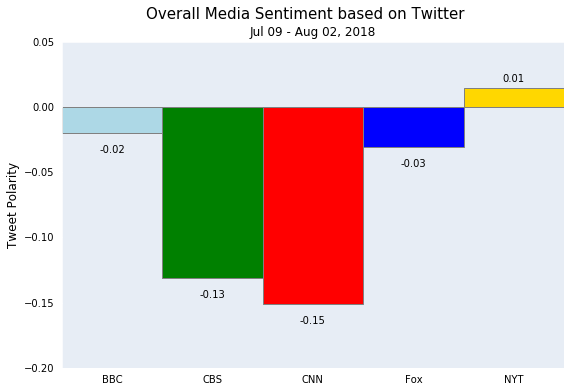

In [9]:
# Plot the overall media sentiment based on Twitter
x = overall_sentiment['Source Account']
y = overall_sentiment['Compound']
colors = list(['lightblue','g','r','b','gold'])

fig, ax = plt.subplots(figsize=(9,6),sharex=True, sharey=True)

ax.bar(x, y, color=colors, align='center', width=1, edgecolor='gray')

# Add labels, tick marks, etc. 
plt.suptitle(f"Overall Media Sentiment based on Twitter", x=0.5, y=0.96, fontsize=15)
plt.title(f"{min_date} - {max_date}", fontsize=12)
plt.ylabel("Tweet Polarity", fontsize=12)
plt.xlim(-0.5, 4.5)
plt.ylim([(round(y.min()*20)/20)-0.05, (round(y.max()*20)/20)+0.05])
ax.patch.set_facecolor('lightsteelblue')
ax.patch.set_alpha(0.3)
plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')


#Use functions to label the percentages of changes
def autolabel(rects):
     for rect in enumerate(rects):
        height = rect[1]
                
        if height > 0:
            label_position = height + 0.005
        else:
            label_position = height - 0.015
    
        plt.text(rect[0], label_position, 
                 str('{:.2f}'.format(height)),
                 color='k',
                 ha='center')

# Call functions to implement the function calls
autolabel(overall_sentiment['Compound'])
                
# # Save the Figure
plt.savefig(f"Overall Media Sentiment on Twitter.png", bbox_inches='tight')

# Show the Figure
plt.show()

In [10]:
sentiments_pd['Tweet Category'].unique()
sentiments_cat = sentiments_pd[sentiments_pd['Tweet Category']!='Other']
sentiments_cat['Tweet Category'].unique()
len(sentiments_cat)/len(sentiments_pd)

0.264

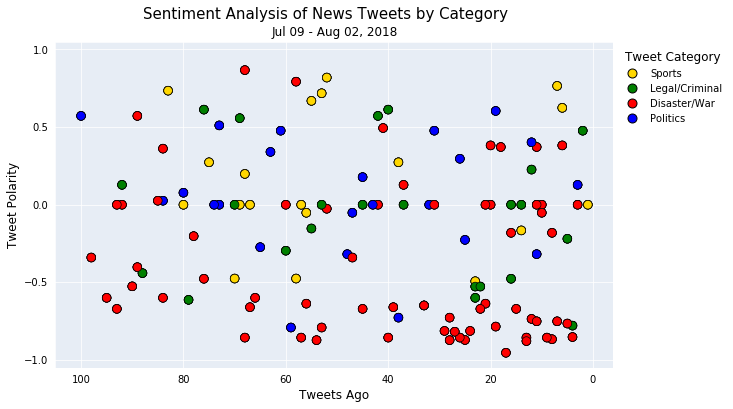

In [11]:
# Scatter plot to show tweet sentiment of individual tweets by media source
x_val = sentiments_cat["Tweets Ago"]
y_val = sentiments_cat["Compound"]
sources = list(sentiments_cat["Tweet Category"].unique())

fig, ax = plt.subplots(figsize=(10,6))
ax.grid()
colors = {'Sports':'gold',
          'Legal/Criminal':'g',
          'Disaster/War':'r',
          'Politics':'b'}

for source, color in zip(sources, colors):
    ax.scatter(x_val, y_val,
               c=sentiments_cat['Tweet Category'].apply(lambda x: colors[x]),
               label=source, marker='o', s=75, edgecolors='k', linewidths=0.7)

# Incorporate other graph properties
plt.suptitle(f"Sentiment Analysis of News Tweets by Category", x=0.5, y=0.96, fontsize=15)
plt.title(f"{min_date} - {max_date}", fontsize=12)
plt.xlim([x_val.max()+5,x_val.min()-5])
plt.ylim([-1.05, 1.05])
plt.yticks(np.arange(-1,1.1, 0.5))
plt.ylabel("Tweet Polarity", fontsize=12)
plt.xlabel("Tweets Ago", fontsize=12)
plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')
ax.patch.set_facecolor('lightsteelblue')
ax.patch.set_alpha(0.3)
ax.grid(c='white')
ax.set_axisbelow('True')
legend_markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', markersize=9, markeredgewidth=1, markeredgecolor='k') for color in colors.values()]
leg = plt.legend(legend_markers, colors.keys(), numpoints=1, bbox_to_anchor=(1,1), frameon=False)
leg.set_title("Tweet Category", prop = {'size':'large'})

# Save image of the Figure
plt.savefig(f"Sentiment Analysis of News Tweets by Category.png", bbox_inches='tight')

# Show the Figure
plt.show()

##  Overall Media Sentiment by Story Category

In [12]:
overall_sentiment = sentiments_pd[['Tweet Category','Compound']].groupby(['Tweet Category']).mean()
overall_sentiment = overall_sentiment.reset_index()
overall_sentiment

,Tweet Category,Compound
0,Disaster/War,-0.374897
1,Legal/Criminal,-0.087183
2,Other,-0.026769
3,Politics,0.060061
4,Sports,0.179642


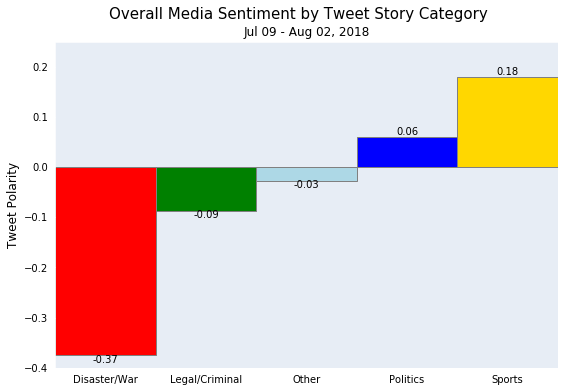

In [13]:
# Plot the overall media sentiment by story category
x = overall_sentiment['Tweet Category']
y = overall_sentiment['Compound']
colors = list(['r','g','lightblue','b','gold'])

fig, ax = plt.subplots(figsize=(9,6),sharex=True, sharey=True)

ax.bar(x, y, color=colors, align='center', width=1, edgecolor='gray')

# Add labels, tick marks, etc. 
plt.suptitle(f"Overall Media Sentiment by Tweet Story Category", x=0.5, y=0.96, fontsize=15)
plt.title(f"{min_date} - {max_date}", fontsize=12)
plt.ylabel("Tweet Polarity", fontsize=12)
plt.xlim(-0.5, 4.5)
plt.ylim([(round(y.min()*20)/20)-0.05, (round(y.max()*20)/20)+0.05])
ax.patch.set_facecolor('lightsteelblue')
ax.patch.set_alpha(0.3)
plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')


#Use functions to label the percentages of changes
def autolabel(rects):
     for rect in enumerate(rects):
        height = rect[1]
                
        if height > 0:
            label_position = height + 0.005
        else:
            label_position = height - 0.015
    
        plt.text(rect[0], label_position, 
                 str('{:.2f}'.format(height)),
                 color='k',
                 ha='center')

# Call functions to implement the function calls
autolabel(overall_sentiment['Compound'])
                
# # Save the Figure
plt.savefig(f"Overall Media Sentiment by Tweet Story Category.png", bbox_inches='tight')

# Show the Figure
plt.show()